In [2]:
# ===============================
# 1. Setup: Install dependencies
# ===============================
# !pip install gdown
# !pip install timm
# !pip install torch torchvision

# ===============================
# 2. Imports
# ===============================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import timm
from tqdm import tqdm
import numpy as np

# Google Drive for checkpoint saving
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 3. Config
# ===============================
CONFIG = {
    "data_root": "/content/data",
    "output_root": "/content/outputs",
    "drive_root": "/content/drive/MyDrive/cifar10_checkpoints",  # 🔹 Drive folder
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 128,
    "test_batch_size": 256,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "target_accuracy": 87.0,   # stop training when at 87% accuracy
    "max_epochs": 60,
    "seed": 42,
    "num_workers": 2,   # safe for Colab
}

os.makedirs(CONFIG["data_root"], exist_ok=True)
os.makedirs(CONFIG["output_root"], exist_ok=True)
os.makedirs(CONFIG["drive_root"], exist_ok=True)  # 🔹 Drive save path

torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

print("Using device:", CONFIG["device"])
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# ===============================
# 4. CIFAR-10 Datasets & Loaders
# ===============================

# --- ResNet transforms (32x32 native) ---
transform_resnet_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_resnet_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# --- ViT transforms (resize to 224x224) ---
transform_vit_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_vit_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# --- CIFAR-10 datasets ---
trainset_resnet = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=True, download=True, transform=transform_resnet_train
)
testset_resnet = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=False, download=True, transform=transform_resnet_test
)

trainset_vit = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=True, download=False, transform=transform_vit_train
)
testset_vit = torchvision.datasets.CIFAR10(
    root=CONFIG["data_root"], train=False, download=False, transform=transform_vit_test
)

# --- Dataloaders ---
trainloader_resnet = DataLoader(trainset_resnet, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
testloader_resnet = DataLoader(testset_resnet, batch_size=CONFIG["test_batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

trainloader_vit = DataLoader(trainset_vit, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
testloader_vit = DataLoader(testset_vit, batch_size=CONFIG["test_batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

# ===============================
# 5. Models (ResNet-50 & ViT-S/16)
# ===============================
resnet50 = torchvision.models.resnet50(weights="IMAGENET1K_V1")
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=10)

resnet50, vit = resnet50.to(CONFIG["device"]), vit.to(CONFIG["device"])

# ===============================
# 6. Checkpoint Utilities
# ===============================
def save_checkpoint(model, name):
    path = os.path.join(CONFIG["drive_root"], f"{name}.pth")
    torch.save(model.state_dict(), path)
    print(f"💾 Saved {name} checkpoint to {path}")

def load_checkpoint(model, name, device):
    path = os.path.join(CONFIG["drive_root"], f"{name}.pth")
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"✅ Loaded checkpoint for {name} from {path}")
    else:
        print(f"⚠️ No checkpoint found for {name}, starting fresh.")
    return model

# ===============================
# 7. Training Utilities
# ===============================
def evaluate(model, dataloader, device):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return 100.0 * correct / total, loss_sum / total

def train_until_target(model, trainloader, testloader, optimizer, criterion,
                       device, name="model"):
    # Try to resume from checkpoint
    model = load_checkpoint(model, name, device)

    for epoch in range(CONFIG["max_epochs"]):
        model.train()
        running_loss = 0.0
        for xb, yb in tqdm(trainloader, desc=f"{name} Epoch {epoch+1}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        train_loss = running_loss / len(trainloader.dataset)
        test_acc, test_loss = evaluate(model, testloader, device)
        print(f"[{name}] Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
              f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%")

        # Save best checkpoint
        save_checkpoint(model, name)

        if test_acc >= CONFIG["target_accuracy"]:
            print(f"🎯 Target {CONFIG['target_accuracy']}% reached for {name}. Stopping training.")
            break
    return model

# ===============================
# 8. Train Both Models (with resume)
# ===============================
criterion = nn.CrossEntropyLoss()

resnet_optimizer = optim.AdamW(resnet50.parameters(), lr=CONFIG["lr"], weight_decay=CONFIG["weight_decay"])
vit_optimizer = optim.AdamW(vit.parameters(), lr=CONFIG["lr"], weight_decay=CONFIG["weight_decay"])

print("\n--- Training ResNet-50 ---")
resnet50 = train_until_target(resnet50, trainloader_resnet, testloader_resnet, resnet_optimizer, criterion, CONFIG["device"], "ResNet50")

print("\n--- Training ViT-S/16 ---")
vit = train_until_target(vit, trainloader_vit, testloader_vit, vit_optimizer, criterion, CONFIG["device"], "ViT-S16")

# ===============================
# 9. Baseline Evaluation
# ===============================
resnet_acc, _ = evaluate(resnet50, testloader_resnet, CONFIG["device"])
vit_acc, _ = evaluate(vit, testloader_vit, CONFIG["device"])

print(f"\n📊 Baseline CIFAR-10 Accuracy:\nResNet-50: {resnet_acc:.2f}%\nViT-S/16: {vit_acc:.2f}%")

# ===============================
# 10. OOD Evaluation (Grayscale)
# ===============================
# ResNet grayscale
transform_gray_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
grayset_resnet = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=True, transform=transform_gray_resnet)
grayloader_resnet = DataLoader(grayset_resnet, batch_size=CONFIG["test_batch_size"], shuffle=False)

# ViT grayscale
transform_gray_vit = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
grayset_vit = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_gray_vit)
grayloader_vit = DataLoader(grayset_vit, batch_size=CONFIG["test_batch_size"], shuffle=False)

print("\n--- OOD Evaluation (Grayscale CIFAR-10) ---")
resnet_acc_gray, _ = evaluate(resnet50, grayloader_resnet, CONFIG["device"])
vit_acc_gray, _ = evaluate(vit, grayloader_vit, CONFIG["device"])
print(f"ResNet-50 on Grayscale CIFAR-10: {resnet_acc_gray:.2f}%")
print(f"ViT-S/16 on Grayscale CIFAR-10: {vit_acc_gray:.2f}%")


Mounted at /content/drive
Using device: cuda
GPU: Tesla T4


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]


--- Training ResNet-50 ---
✅ Loaded checkpoint for ResNet50 from /content/drive/MyDrive/cifar10_checkpoints/ResNet50.pth


[ResNet50] Epoch 1: Train Loss=0.1089, Test Loss=0.5220, Test Acc=86.67%
💾 Saved ResNet50 checkpoint to /content/drive/MyDrive/cifar10_checkpoints/ResNet50.pth


[ResNet50] Epoch 2: Train Loss=0.0989, Test Loss=0.5258, Test Acc=86.95%
💾 Saved ResNet50 checkpoint to /content/drive/MyDrive/cifar10_checkpoints/ResNet50.pth


[ResNet50] Epoch 3: Train Loss=0.0916, Test Loss=0.5132, Test Acc=87.03%
💾 Saved ResNet50 checkpoint to /content/drive/MyDrive/cifar10_checkpoints/ResNet50.pth
🎯 Target 87.0% reached for ResNet50. Stopping training.

--- Training ViT-S/16 ---
✅ Loaded checkpoint for ViT-S16 from /content/drive/MyDrive/cifar10_checkpoints/ViT-S16.pth


[ViT-S16] Epoch 1: Train Loss=0.0475, Test Loss=0.0966, Test Acc=96.79%
💾 Saved ViT-S16 checkpoint to /content/drive/MyDrive/cifar10_checkpoints/ViT-S16.pth
🎯 Target 87.0% reached for ViT-S16. Stopping training.

📊 Baseline CIFAR-10 Accuracy:
ResNet-50: 87.03%
ViT-S/16: 96.79%

--- OOD Evaluation (Grayscale CIFAR-10) ---
ResNet-50 on Grayscale CIFAR-10: 77.05%
ViT-S/16 on Grayscale CIFAR-10: 90.17%


In [7]:

# ===============================
# 11. OOD Evaluation (Custom Cue-Conflict Dataset with 5 classes of CIFAR only)
# ===============================
import zipfile
import os

# Path to uploaded zip file
zip_path = "/content/cue-conflict_CIFAR-5.zip"
extract_dir = "/content/cue_conflict"

# Extract only once
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("Extracted dataset to:", extract_dir)
!ls -R {extract_dir} | head -50  # show first 50 lines of folder structure

# Now use this as the dataset root
cue_conflict_root = extract_dir

from torchvision.datasets import ImageFolder

# --- ResNet transforms (32x32 native) ---
transform_cue_resnet = transforms.Compose([
    transforms.Resize((32, 32)),   # CIFAR resolution
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# --- ViT transforms (resize to 224x224) ---
transform_cue_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load datasets (ImageFolder expects: root/class_name/*.png)
cue_resnet = ImageFolder(root=cue_conflict_root, transform=transform_cue_resnet)
cue_vit = ImageFolder(root=cue_conflict_root, transform=transform_cue_vit)

cue_loader_resnet = DataLoader(cue_resnet, batch_size=CONFIG["test_batch_size"], shuffle=False)
cue_loader_vit = DataLoader(cue_vit, batch_size=CONFIG["test_batch_size"], shuffle=False)

print("\n--- OOD Evaluation (Cue-Conflict CIFAR-5) ---")
resnet_acc_cue, _ = evaluate(resnet50, cue_loader_resnet, CONFIG["device"])
vit_acc_cue, _ = evaluate(vit, cue_loader_vit, CONFIG["device"])
print(f"ResNet-50 on Cue-Conflict CIFAR-5: {resnet_acc_cue:.2f}%")
print(f"ViT-S/16 on Cue-Conflict CIFAR-5: {vit_acc_cue:.2f}%")


Extracted dataset to: /content/cue_conflict
/content/cue_conflict:
cue-conflict_CIFAR-5

/content/cue_conflict/cue-conflict_CIFAR-5:
airplane
bird
car
cat
truck

/content/cue_conflict/cue-conflict_CIFAR-5/airplane:
airplane10-airplane1.png
airplane10-bear3.png
airplane10-boat3.png
airplane10-car3.png
airplane10-cat2.png
airplane10-dog3.png
airplane10-elephant1.png
airplane10-knife3.png
airplane10-oven2.png
airplane10-truck1.png
airplane1-bicycle2.png
airplane1-chair2.png
airplane1-clock1.png
airplane1-elephant1.png
airplane2-bear1.png
airplane2-bicycle1.png
airplane2-bird3.png
airplane2-bottle1.png
airplane2-cat1.png
airplane2-dog1.png
airplane3-airplane2.png
airplane3-car1.png
airplane3-cat1.png
airplane3-chair3.png
airplane3-clock1.png
airplane3-dog1.png
airplane3-elephant1.png
airplane3-keyboard2.png
airplane3-oven1.png
airplane4-airplane1.png
airplane4-bear3.png
airplane4-bicycle2.png
airplane4-bird3.png
airplane4-boat3.png
airplane4-bottle1.png
airplane4-car1.png
airplane4-cat3.pn

In [9]:
import random
from torchvision.transforms import functional as F
from PIL import Image

# ===============================
# Custom OOD Transforms (Translation, Patch Shuffling, Occlusion)
# ===============================

class RandomTranslate:
    """Shift image by up to ±max_shift pixels."""
    def __init__(self, max_shift=4):
        self.max_shift = max_shift

    def __call__(self, img):
        dx = random.randint(-self.max_shift, self.max_shift)
        dy = random.randint(-self.max_shift, self.max_shift)
        return F.affine(img, angle=0, translate=(dx, dy), scale=1.0, shear=0)


class PatchShuffle:
    """Split image into patches and shuffle them."""
    def __init__(self, grid_size=4):
        self.grid_size = grid_size

    def __call__(self, img):
        w, h = img.size
        patch_w, patch_h = w // self.grid_size, h // self.grid_size
        patches = []

        # extract patches
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch = img.crop((j*patch_w, i*patch_h, (j+1)*patch_w, (i+1)*patch_h))
                patches.append(patch)

        random.shuffle(patches)

        # reconstruct shuffled image
        new_img = Image.new("RGB", (w, h))
        idx = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                new_img.paste(patches[idx], (j*patch_w, i*patch_h))
                idx += 1

        return new_img


class PatchOcclusion:
    """Occlude (mask) a random square patch."""
    def __init__(self, occ_size=8):
        self.occ_size = occ_size

    def __call__(self, img):
        w, h = img.size
        x0 = random.randint(0, w - self.occ_size)
        y0 = random.randint(0, h - self.occ_size)

        img = img.copy()
        occluder = Image.new("RGB", (self.occ_size, self.occ_size), (0, 0, 0))
        img.paste(occluder, (x0, y0))
        return img

# ===============================
# Define OOD Datasets
# ===============================

# --- Translation ---
transform_translate_resnet = transforms.Compose([
    RandomTranslate(max_shift=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
translate_resnet = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_translate_resnet)
translate_loader_resnet = DataLoader(translate_resnet, batch_size=CONFIG["test_batch_size"], shuffle=False)

transform_translate_vit = transforms.Compose([
    transforms.Resize(224),
    RandomTranslate(max_shift=8),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
translate_vit = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_translate_vit)
translate_loader_vit = DataLoader(translate_vit, batch_size=CONFIG["test_batch_size"], shuffle=False)

# --- Patch Shuffling ---
transform_shuffle_resnet = transforms.Compose([
    PatchShuffle(grid_size=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
shuffle_resnet = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_shuffle_resnet)
shuffle_loader_resnet = DataLoader(shuffle_resnet, batch_size=CONFIG["test_batch_size"], shuffle=False)

transform_shuffle_vit = transforms.Compose([
    transforms.Resize(224),
    PatchShuffle(grid_size=7),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
shuffle_vit = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_shuffle_vit)
shuffle_loader_vit = DataLoader(shuffle_vit, batch_size=CONFIG["test_batch_size"], shuffle=False)

# --- Patch Occlusion ---
transform_occ_resnet = transforms.Compose([
    PatchOcclusion(occ_size=8),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
occ_resnet = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_occ_resnet)
occ_loader_resnet = DataLoader(occ_resnet, batch_size=CONFIG["test_batch_size"], shuffle=False)

transform_occ_vit = transforms.Compose([
    transforms.Resize(224),
    PatchOcclusion(occ_size=32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
occ_vit = torchvision.datasets.CIFAR10(root=CONFIG["data_root"], train=False, download=False, transform=transform_occ_vit)
occ_loader_vit = DataLoader(occ_vit, batch_size=CONFIG["test_batch_size"], shuffle=False)

# ===============================
# Run OOD Evaluations
# ===============================
print("\n--- OOD Evaluation (Translation) ---")
resnet_acc_trans, _ = evaluate(resnet50, translate_loader_resnet, CONFIG["device"])
vit_acc_trans, _ = evaluate(vit, translate_loader_vit, CONFIG["device"])
print(f"ResNet-50: {resnet_acc_trans:.2f}% | ViT-S/16: {vit_acc_trans:.2f}%")

print("\n--- OOD Evaluation (Patch Shuffling) ---")
resnet_acc_shuffle, _ = evaluate(resnet50, shuffle_loader_resnet, CONFIG["device"])
vit_acc_shuffle, _ = evaluate(vit, shuffle_loader_vit, CONFIG["device"])
print(f"ResNet-50: {resnet_acc_shuffle:.2f}% | ViT-S/16: {vit_acc_shuffle:.2f}%")

print("\n--- OOD Evaluation (Patch Occlusion) ---")
resnet_acc_occ, _ = evaluate(resnet50, occ_loader_resnet, CONFIG["device"])
vit_acc_occ, _ = evaluate(vit, occ_loader_vit, CONFIG["device"])
print(f"ResNet-50: {resnet_acc_occ:.2f}% | ViT-S/16: {vit_acc_occ:.2f}%")



--- OOD Evaluation (Translation) ---
ResNet-50: 85.96% | ViT-S/16: 96.66%

--- OOD Evaluation (Patch Shuffling) ---
ResNet-50: 28.27% | ViT-S/16: 48.19%

--- OOD Evaluation (Patch Occlusion) ---
ResNet-50: 75.60% | ViT-S/16: 96.63%


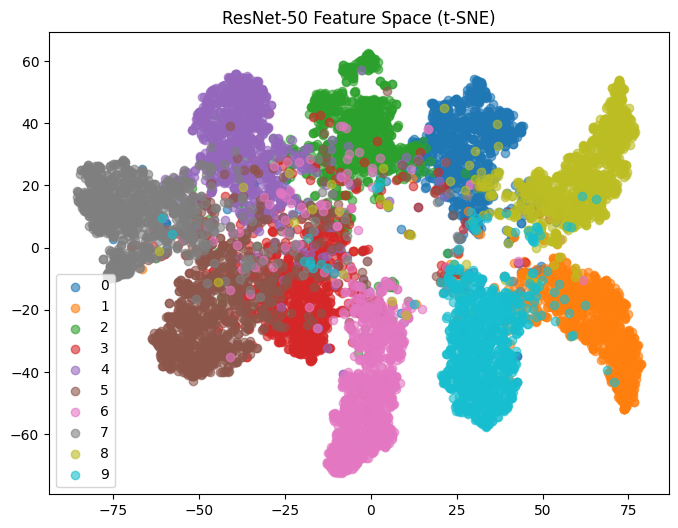

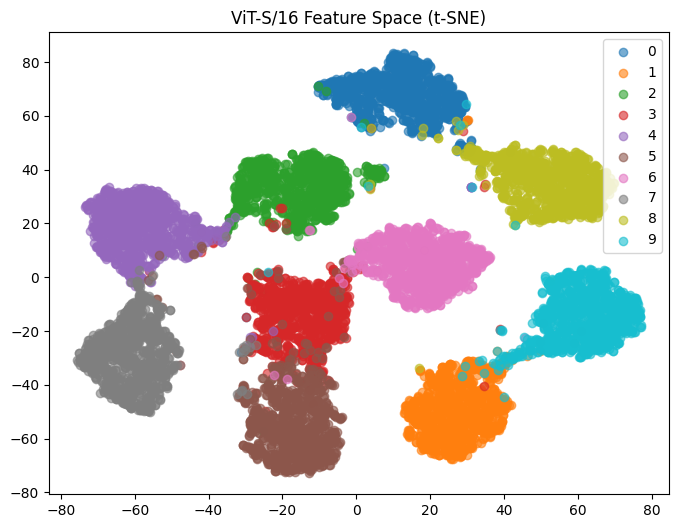

In [10]:
# ===============================
# Feature Representation Analysis (t-SNE/PCA)
# ===============================
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def extract_features(model, dataloader, device, penultimate=True):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)

            if penultimate:
                if isinstance(model, torchvision.models.ResNet):
                    x = model.conv1(xb)
                    x = model.bn1(x)
                    x = model.relu(x)
                    x = model.maxpool(x)
                    x = model.layer1(x)
                    x = model.layer2(x)
                    x = model.layer3(x)
                    x = model.layer4(x)
                    x = torch.flatten(x, 1)
                elif 'vit' in model.__class__.__name__.lower():
                    x = model.forward_features(xb)
                else:
                    x = model(xb)
            else:
                x = model(xb)

            features.append(x.cpu().numpy())
            labels.append(yb.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def plot_tsne(features, labels, title="t-SNE Plot"):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb = tsne.fit_transform(features)
    plt.figure(figsize=(8,6))
    for i in np.unique(labels):
        idx = labels == i
        plt.scatter(emb[idx,0], emb[idx,1], label=str(i), alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.show()

# Example: Use subset of testloader for speed
subset_loader_resnet = DataLoader(testset_resnet, batch_size=256, shuffle=True)
subset_loader_vit = DataLoader(testset_vit, batch_size=256, shuffle=True)

# ResNet features
resnet_features, resnet_labels = extract_features(resnet50, subset_loader_resnet, CONFIG["device"])
plot_tsne(resnet_features, resnet_labels, title="ResNet-50 Feature Space (t-SNE)")

# ViT features
vit_features, vit_labels = extract_features(vit, subset_loader_vit, CONFIG["device"])
plot_tsne(vit_features, vit_labels, title="ViT-S/16 Feature Space (t-SNE)")


In [ ]:
!pip install "deeplake<4"

In [ ]:
# ===============================
# PACS OOD Evaluation
# ===============================
import deeplake
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms

# --- Load PACS test dataset from Deep Lake ---
pacs_ds = deeplake.load("hub://activeloop/pacs-test")  # default: test split

# --- Define transforms ---
# ResNet: keep original size
transform_resnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# ViT: resize to 224x224
transform_vit = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# --- Collate function for Deep Lake dataset ---
def pacs_collate(batch, model_type="resnet"):
    images = []
    labels = []
    for item in batch:
        img = item['images'].numpy()       # numpy array
        label = int(item['labels'].numpy())
        # Apply appropriate transform
        if model_type == "resnet":
            img = transform_resnet(img)
        else:
            img = transform_vit(img)
        images.append(img)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)

# --- DataLoaders ---
batch_size = 32

pacs_loader_resnet = DataLoader(pacs_ds, batch_size=batch_size, shuffle=False,
                               collate_fn=lambda b: pacs_collate(b, "resnet"))
pacs_loader_vit = DataLoader(pacs_ds, batch_size=batch_size, shuffle=False,
                             collate_fn=lambda b: pacs_collate(b, "vit"))

# --- Evaluation function ---
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return 100.0 * correct / total

# --- Run PACS OOD evaluation ---
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet_acc_pacs = evaluate(resnet50, pacs_loader_resnet, device)
vit_acc_pacs = evaluate(vit, pacs_loader_vit, device)

print(f"ResNet-50 on PACS: {resnet_acc_pacs:.2f}%")
print(f"ViT-S/16 on PACS: {vit_acc_pacs:.2f}%")
